In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [2]:
# Loading the CSV file

df = pd.read_csv('../api_data_modeling/climate_api_data_2017_2021.csv')

df

,date,geocodigo,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,precip_tot,pressao_min,pressao_med,pressao_max,umid_min,umid_med,umid_max
0,2017-01-01,1302603,23.6111,25.3502,27.7248,0.1231,0.5659,1.3036,4.5273,0.9960,0.9983,1.0013,79.6839,90.0431,99.0368
1,2017-01-02,1302603,24.0199,26.1471,29.4771,0.0000,0.2304,1.6464,1.8431,0.9945,0.9979,1.0004,72.0835,87.2796,97.3930
2,2017-01-03,1302603,23.1482,25.8223,29.4092,0.0140,0.9063,3.2519,7.2501,0.9935,0.9974,0.9997,67.4282,84.7726,93.5927
3,2017-01-04,1302603,24.4720,26.4360,28.7671,0.0000,0.2244,0.5448,1.7950,0.9929,0.9965,0.9996,73.6756,84.6681,93.5752
4,2017-01-05,1302603,24.0013,26.6296,30.2719,0.0022,0.3966,1.6309,3.1725,0.9935,0.9962,0.9990,67.6898,83.8311,93.7440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2021-12-27,1302603,23.9273,25.7716,27.6912,0.0000,0.6288,2.7231,5.0304,0.9945,0.9964,0.9992,86.0339,89.9206,93.5145
1822,2021-12-28,1302603,22.9484,25.9423,31.5794,0.0003,0.1879,1.2172,1.5033,0.9945,0.9967,0.9993,65.6959,85.8707,96.1019
1823,2021-12-29,1302603,24.7293,27.4349,31.0417,0.0000,0.0930,0.6209,0.7437,0.9939,0.9969,0.9985,66.3288,82.4274,93.6948
1824,2021-12-30,1302603,24.3319,25.5776,27.5484,0.0000,1.2250,5.8845,9.8002,0.9956,0.9970,0.9986,81.8586,90.1047,93.3572


#### Model with approximated climate data with T(r) and R(t) functions:

In [3]:
def population_dynamics_model(t, z, T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                               B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                               D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                               N, M, E_M0, I_H0, I_M0, R_H0, mu_H):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Temperature and rainfall functions
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Larval development duration
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Daily mosquito survival rate
    def p(Temp):
        return np.exp(-1 / (A * Temp**2 + B * Temp + C))
    
    # Larval survival probability dependent on temperature and rainfall
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4 * p_ML / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    def p_LRT(Rain, Temp):
        return p_LR(Rain) * p_LT(Temp)
    
    # Egg and pupa survival probability dependent on rainfall 
    def p_ER(Rain):
        return (4 * p_ME / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    # Pupa survival probability dependent on rainfall 
    def p_PR(Rain):
        return (4 * p_MP / R_L**2) * Rain * (max(1e-5, R_L - Rain))

    # Sporogonic cycle duration
    def tau_M(Temp):
        return DD / (max(1e-5, Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Exposed-to-infected rate (1/Sporogonic cycle duration)
    def b3(tau_M, Temp):
        return 1 / tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Defining the mosquito survival function
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Mosquito mortality rate
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calculate biting rate and transmission probability
    def a(Temp):
        return max(1e-5, (Temp - T_prime) / D1)
    
    a_curr = a(T_curr)
    
    def b(Rain, Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain, Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = mu_H * N - a_curr * b2 * (I_M / N) * S_H - mu_H * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H - mu_H * I_H
    dRhdt = gamma * I_H - mu_H * R_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [4]:
def R0_sir(a, b2, gamma, mu_H):
    return abs((a * b2) / (gamma + mu_H))
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, b1, b3, l, mu):
    return abs((a * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, b1, b2, b3, gamma, l, mu, mu_H):
    return abs(((a**2 * b1 * b2 * b3) / (mu*(gamma + mu_H)*(b3 + l + mu)))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [5]:
def calculate_initial_values(R_L, T_prime, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_prime)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, b2, gamma, mu_H)
    initial_R0_sei = R0_sei(a0, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, b1, b2, b30, gamma, l0, mu0, mu_H)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full

In [7]:
T_prime=25.6

T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04

A=12.5
B=15
C=-48.78

mu_H=0.00004 # estimated births per day per person in rural Manaus from 2017 to 2021
k=1

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma=1/120
R_L=450
N=9586    # estimated rural poulation in Manaus in 2017
M=300000  #0

E_M0=1
I_M0=0 # None
I_H0=1
R_H0=0

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0 - R_H0
S_M0 = M - E_M0 - I_M0

In [8]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H)

In [9]:
initial_R0_sir, initial_R0_sei, initial_R0_full = calculate_initial_values(R_L, T_prime, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H)

In [10]:
print(f'R0 (SIR) = {initial_R0_sir} \nR0 (SEI) = {initial_R0_sei}\nR0 (Full) = {initial_R0_full}')

R0 (SIR) = 0.25900182521296633 
R0 (SEI) = 0.9002047882569278
R0 (Full) = 0.48286093569887817


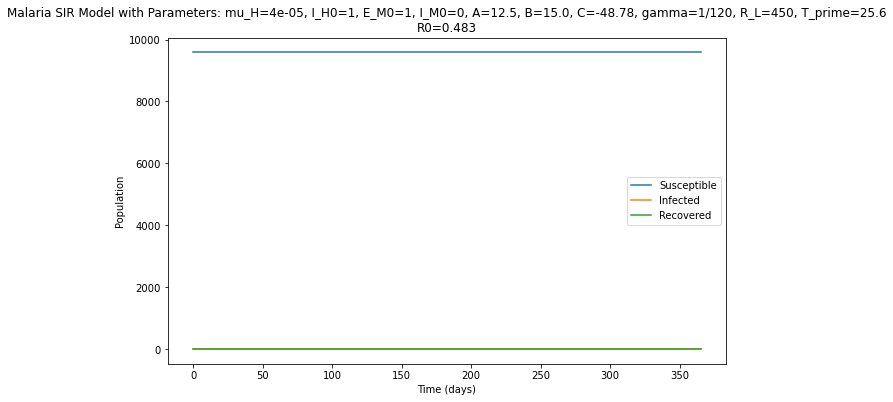

In [11]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(population_dynamics_model, [0, 365], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

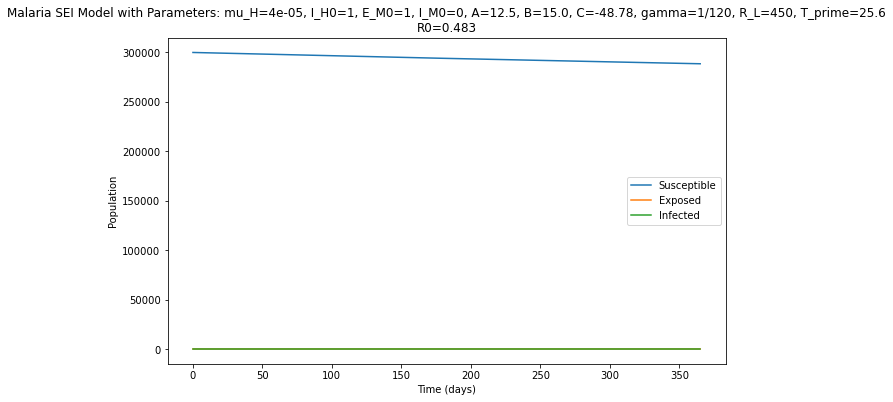

In [12]:
t_eval = np.linspace(0, 365, 1000)  # Evaluate the solution at 1000 points between 0 and 365
sol = solve_ivp(population_dynamics_model, [0, 365], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

#### Analyzing in 5 years:

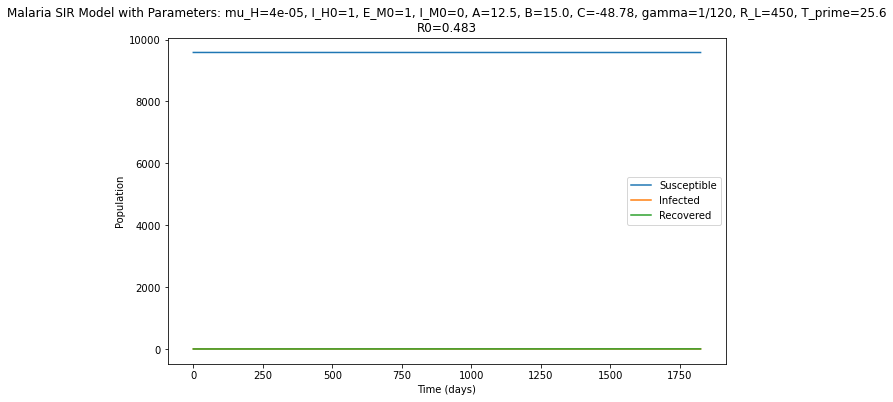

In [13]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

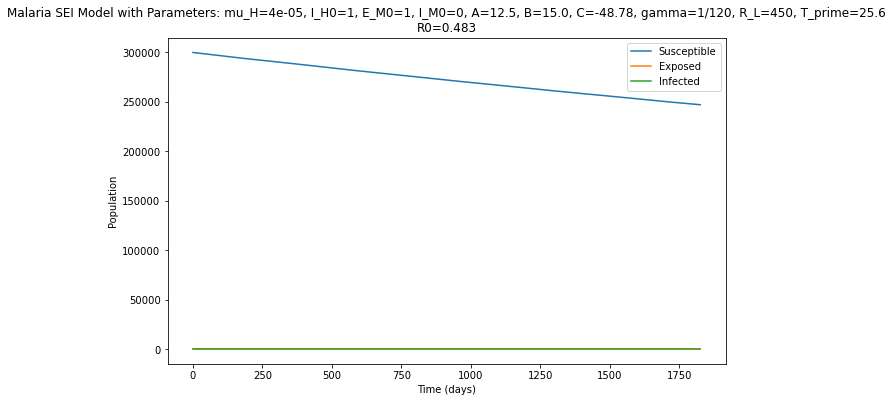

In [14]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

#### Modeling with true data:

In [15]:
def population_dynamics_model_actual_data(t, z, df, T_prime,
                               B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                               D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                               N, M, E_M0, I_H0, I_M0, R_H0, mu_H):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    #     Temperature and rain functions
    #     def Temp(t):
    #         return T1 * (1 + T2 * cos(omega1 * t - phi1))

    #     def Rain(t):
    #         return R1 * (1 + R2 * cos(omega2 * t - phi2))

    #     R_curr = Rain(t)
    #     T_curr = Temp(t)
    
    # Get the closest integer day to use for indexing
    day_index = int(t)  

    if day_index >= len(df):
        day_index = len(df) - 1  # To avoid out-of-bounds issues
    
    T_curr = df.loc[day_index, 'temp_med']
    R_curr = df.loc[day_index, 'precip_med']
    
    # Larval development duration
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Daily mosquito survival rate
    def p(Temp):
        return np.exp(-1 / (A * Temp**2 + B * Temp + C))
    
    # Larval survival probability dependent on temperature and rainfall
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4 * p_ML / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    def p_LRT(Rain, Temp):
        return p_LR(Rain) * p_LT(Temp)
    
    # Egg and pupa survival probability dependent on rainfall 
    def p_ER(Rain):
        return (4 * p_ME / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    # Pupa survival probability dependent on rainfall 
    def p_PR(Rain):
        return (4 * p_MP / R_L**2) * Rain * (max(1e-5, R_L - Rain))

    # Sporogonic cycle duration
    def tau_M(Temp):
        return DD / (max(1e-5, Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Exposed-to-infected rate (1/Sporogonic cycle duration)
    def b3(tau_M, Temp):
        return 1 / tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Defining the mosquito survival function
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Mosquito mortality rate
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calculate biting rate and transmission probability
    def a(Temp):
        return max(1e-5, (Temp - T_prime) / D1)
    
    a_curr = a(T_curr)
    
    def b(Rain, Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain, Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = mu_H * N - a_curr * b2 * (I_M / N) * S_H - mu_H * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H - mu_H * I_H
    dRhdt = gamma * I_H - mu_H * R_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [16]:
data_args = (df, T_prime, B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H)

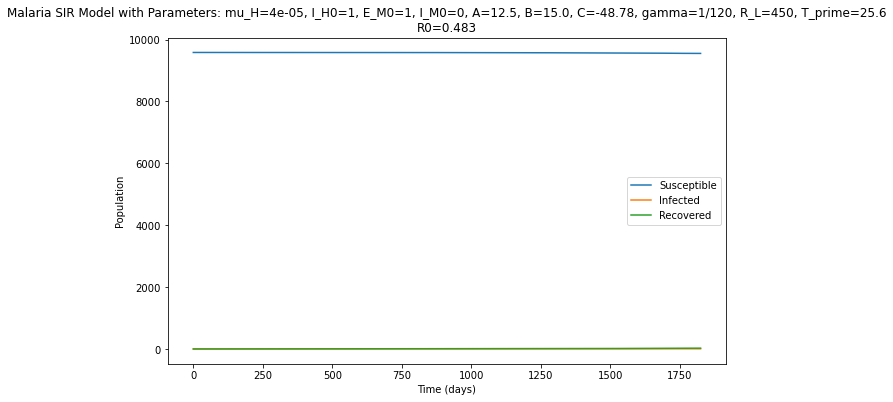

In [17]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model_actual_data, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=data_args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Susceptible')
plt.plot(times, I_H, label='Infected')
plt.plot(times, R_H, label='Recovered')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SIR Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()

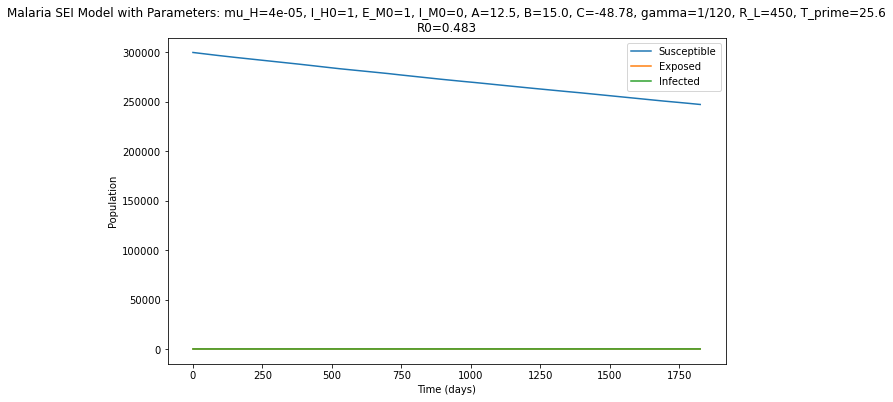

In [18]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
sol = solve_ivp(population_dynamics_model_actual_data, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=data_args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Susceptible')
plt.plot(times, E_M, label='Exposed')
plt.plot(times, I_M, label='Infected')

plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Malaria SEI Model with Parameters: mu_H={round(mu_H, 5)}, I_H0={I_H0}, E_M0={E_M0}, I_M0={I_M0}, A={round(A, 2)}, B={round(B, 2)}, C={round(C, 2)}, gamma={gamma}, R_L={R_L}, T_prime={round(T_prime, 2)}\nR0={round(initial_R0_full, 3)}')

plt.legend()

plt.show()